<a href="https://colab.research.google.com/github/ashishkumar2018/ISE/blob/main/Image_to_Image_search_using_Faiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
%cd /content/drive/MyDrive/ISE

/content/drive/.shortcut-targets-by-id/1vQNEUosrvA6-U2EwBL3g7Qxd85UyIdPd/ISE


In [82]:
import numpy as np
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model

## Installing Faiss

In [83]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
import faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Requirement already up-to-date: faiss in /usr/local/lib/python3.7/dist-packages (1.5.3)
Requirement already up-to-date: faiss-gpu in /usr/local/lib/python3.7/dist-packages (1.7.1.post1)


## Read Dataset and store 

In [84]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [85]:
dataset_generator = datagen.flow_from_directory(
    directory="./dataset",
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='sparse',
)
fp=dataset_generator.filepaths

Found 1597 images belonging to 32 classes.


## Loading The dataset(Computed In Previous Project)

In [86]:
X=np.load('./final/Xdat.npy')
y=np.load('./final/ydat.npy')

## Loading VGG16 model with Trained Weight

In [87]:
model = VGG16( weights='imagenet',include_top=True)

In [88]:
for layer in model.layers:
 layer.trainable = False
model2 = Model(inputs=model.input,outputs=model.get_layer('fc2').output)

In [89]:
print(model2.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [90]:
image_embeddings=model2.predict(X)

## Function to print Similar Image

In [91]:
def image_to_image_search(distances,img_path):
  print("Search image: ")
  from IPython.display import Image, display
  display(Image(img_path))
  import cv2
  from matplotlib import pyplot as plt
  print("Similar images-")
  fig = plt.figure(figsize=(24, 10))
  fig.tight_layout()
  rows = 2
  columns = 4
  k=1
  for i in distances[0]:
    Image4 = cv2.imread(fp[i])
    fig.add_subplot(rows, columns, k)
    image = cv2.cvtColor(Image4, cv2.COLOR_BGR2RGB)
    plt.imshow(image,aspect="auto")
    plt.axis('off')
    k=k+1
  plt.subplots_adjust( wspace=0.01, hspace=0.01)

## Index Image Embedding(Based on Squared Euclidean Distance)

In [92]:
d=4096
index1=faiss.IndexFlatL2(d)
print(index1.is_trained)
index1.add(image_embeddings)             
print(index1.ntotal)

True
1597


Search image: 


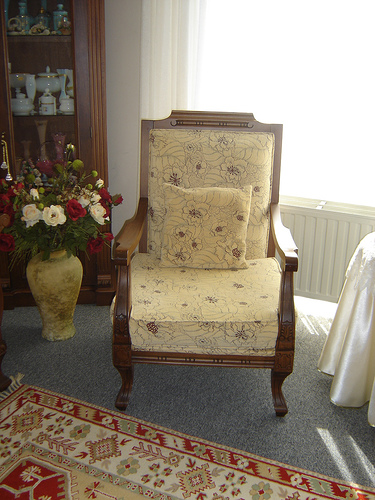

Similar images-


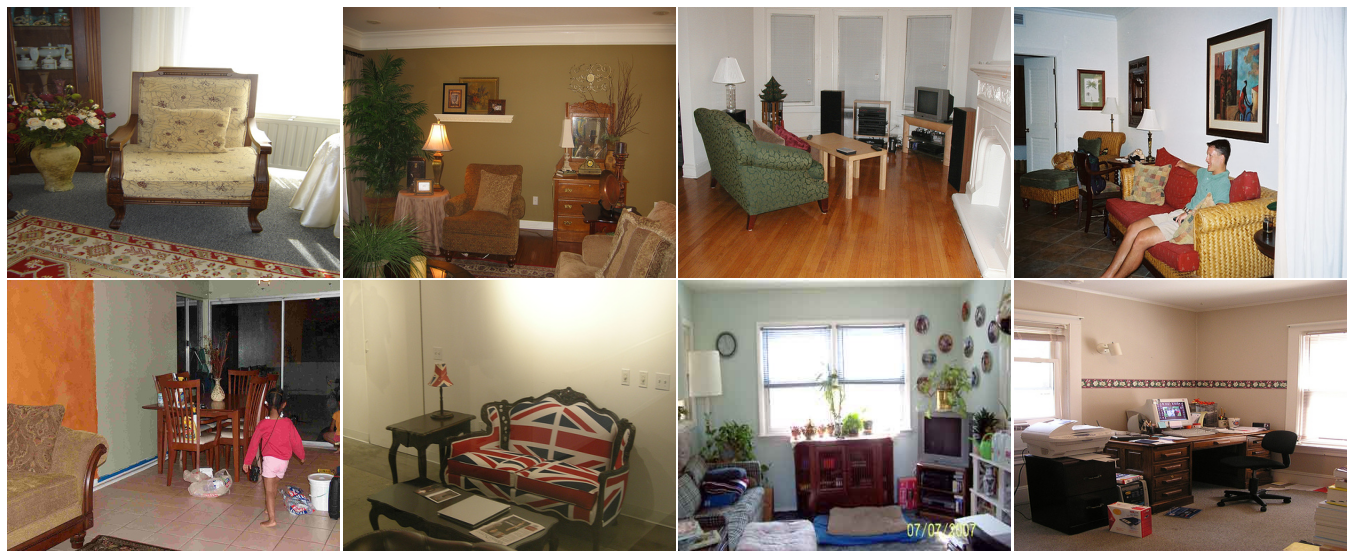

In [93]:
img_embed=image_embeddings[789]
img_path=fp[789]
img_embed=np.reshape(img_embed,(1,4096))
D,distances = index1.search(img_embed,8) # search
image_to_image_search(distances,img_path)

## Indexing Image Embeeding(For Faster Search)

In [94]:
nlist=100
quantizer= faiss.IndexFlatL2(d)
index2=faiss.IndexIVFFlat(quantizer,d,nlist)
assert not index2.is_trained
index2.train(image_embeddings)
assert index2,is_trained
index2.add(image_embeddings)

Search image: 


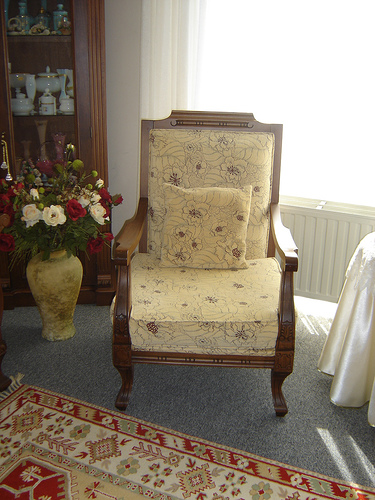

Similar images-


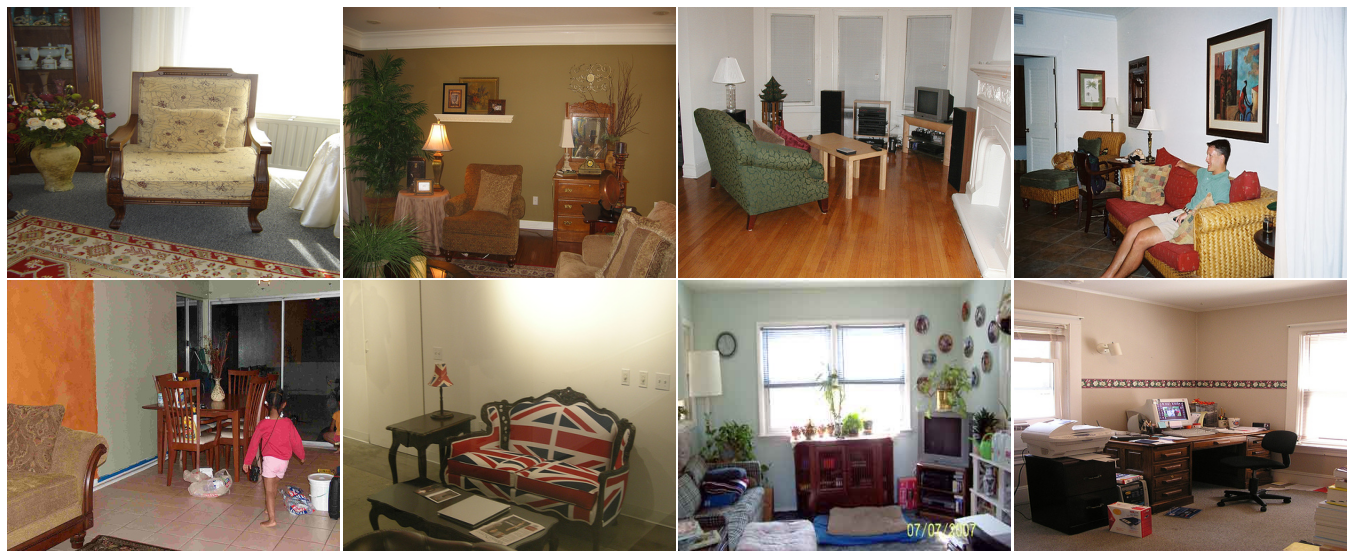

In [95]:
img_embed1=image_embeddings[789]
img_path=fp[789]
img_embed1=np.reshape(img_embed1,(1,4096))
index2.nprobe=10;
D,distances = index2.search(img_embed1,8) # search
image_to_image_search(distances,img_path)

# Indexing Image Embedding(For Lower Memory Usage)

In [96]:
nlist=100
m=8
quantizer=faiss.IndexFlatL2(d)
index3=faiss.IndexIVFPQ(quantizer,d,nlist,m,8); # 8 specifies that each sub-vector is encoded as 8 bits
index3.train(image_embeddings)
index3.add(image_embeddings)

Search image: 


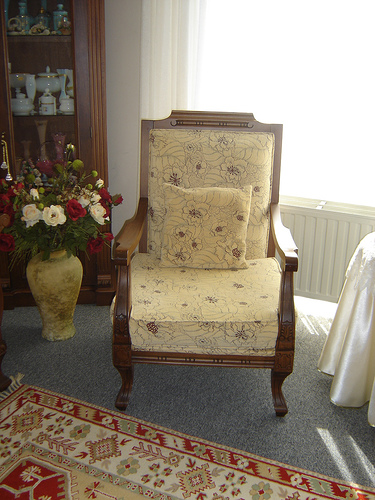

Similar images-


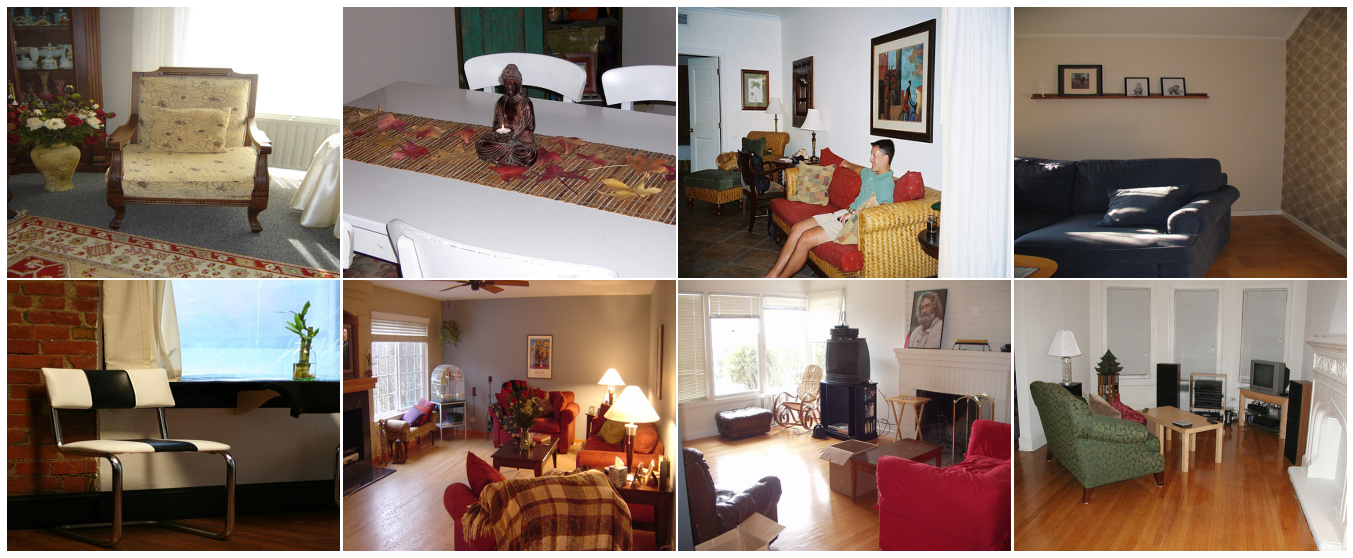

In [97]:
img_embed2=image_embeddings[789]
img_path=fp[789]
img_embed2=np.reshape(img_embed2,(1,4096))
index3.nprobe=10;
D,distances = index3.search(img_embed2,8) # search
image_to_image_search(distances,img_path)

## Indexing Image Embedding(Based on maximum inner product)

In [98]:
index4= faiss.IndexFlatIP(d)
print(index4.is_trained)
index4.add(image_embeddings)
print(index4.ntotal)

True
1597


Search image: 


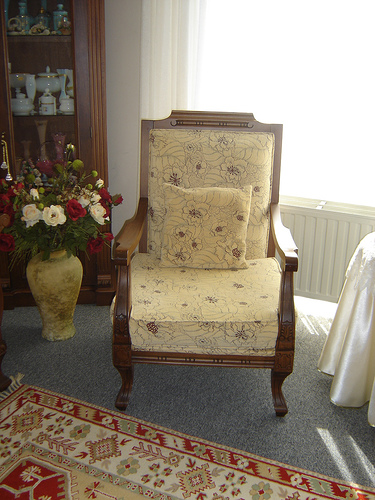

Similar images-


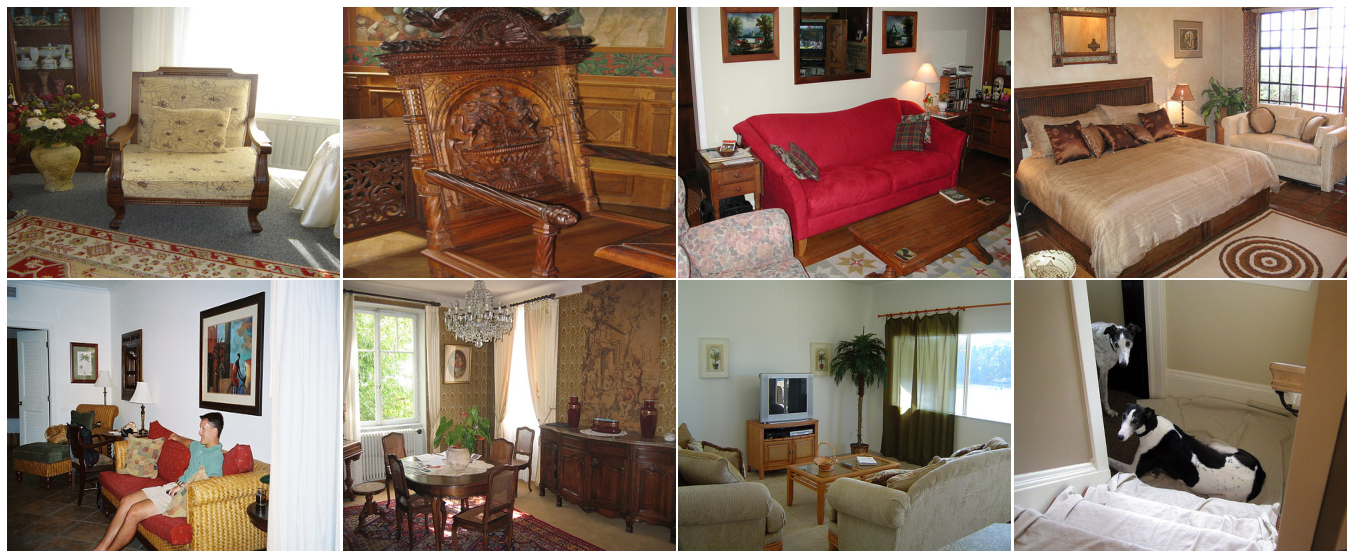

In [99]:
img_embed3=image_embeddings[789]
img_path=fp[789]
img_embed3=np.reshape(img_embed3,(1,4096))
D,distances= index4.search(img_embed3,8)
image_to_image_search(distances,img_path)

## Indexing Image Embedding(Based on Cosine Similarity)

In [100]:
index5=faiss.IndexFlatIP(d)
training_vectors=image_embeddings
faiss.normalize_L2(training_vectors)
index5.add(training_vectors)

Search image: 


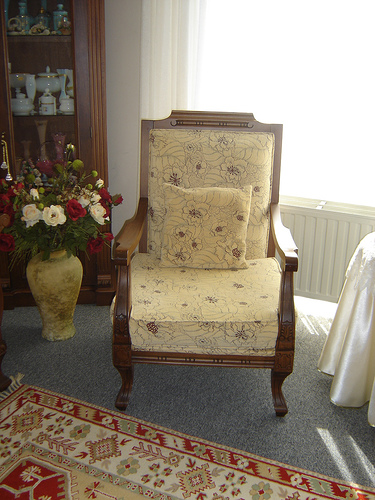

Similar images-


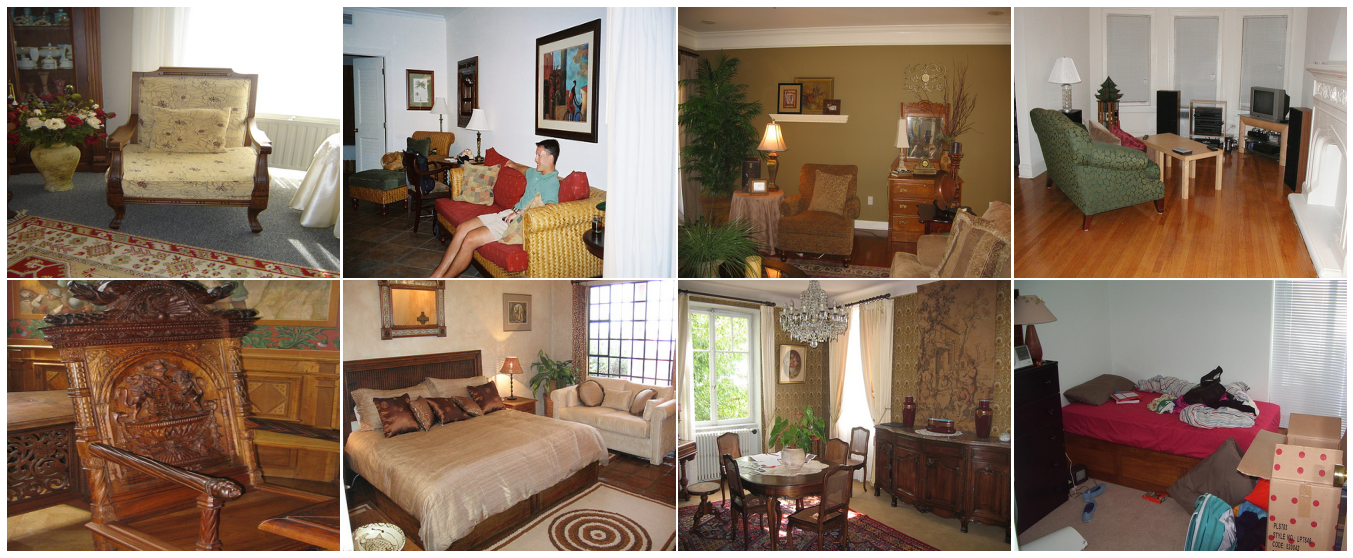

In [101]:
img_embed4=image_embeddings[789]
img_path=fp[789]
img_embed4=np.reshape(img_embed4,(1,4096))
faiss.normalize_L2(img_embed4)
D,distances= index5.search(img_embed4,8)
image_to_image_search(distances,img_path)